In [1]:
import sys
import warnings

warnings.filterwarnings("ignore")
sys.path.append('../../picking/SeismicPro/')

import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from seismicpro.batchflow import B, V, W
from seismicpro.batchflow.models.torch import ResNet34, TorchModel
from seismicpro.src import SeismicDataset, FieldIndex, TraceIndex, seismic_plot

In [2]:
markup_path = '/notebooks/picking/data/targets.csv'
path_raw = '/notebooks/picking/data/traces.sgy'

In [3]:
import pandas as pd
data = pd.read_csv(markup_path)
data.head()
ind = FieldIndex(name='raw', path=path_raw).get_df()
new_path = ind.file_id.iloc[0]['raw']
data.file_id = new_path
data.to_csv(markup_path, index=False)

In [4]:
index = FieldIndex(name='raw', path=path_raw, markup_path=markup_path)

In [5]:
batch = (SeismicDataset(index).next_batch(batch_size=1)
        .load(components='raw', fmt='segy')
        .load(components='markup', fmt='picks'))

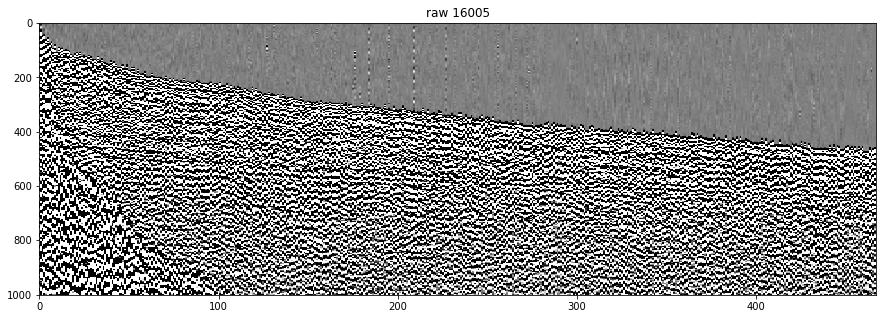

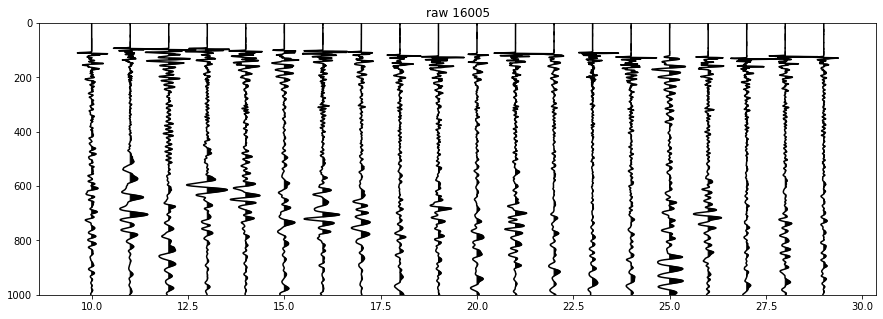

In [6]:
cv = 1000
(batch.seismic_plot('raw', index.indices[0], cmap='gray', figsize=(15,5), vmax=cv, vmin=-cv)
      .seismic_plot('raw', index.indices[0], cmap='gray', figsize=(15,5), vmax=cv, vmin=-cv,
                    wiggle=True, xlim=(10, 30), ylim=(0,1000), std=0.1))

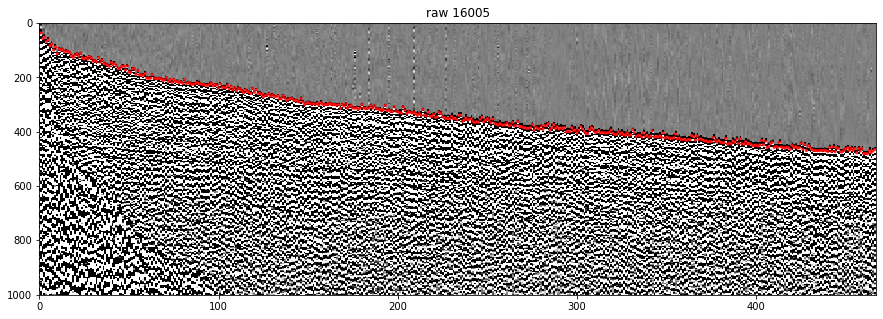

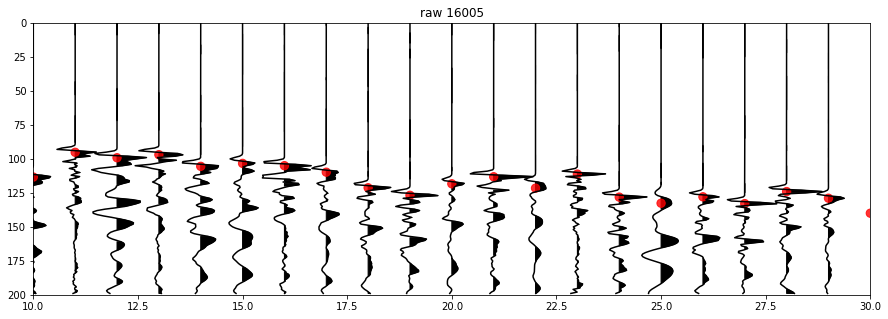

In [14]:
cv = 1000
(batch.seismic_plot('raw', index.indices[0], src_picking='markup', cmap='gray',
                     figsize=(15,5), vmax=cv, vmin=-cv, s=5, scatter_color='r')
      .seismic_plot('raw', index.indices[0], src_picking='markup', cmap='gray',
                    figsize=(15,5), vmax=cv, vmin=-cv, s=70, scatter_color='r',
                    wiggle=True, xlim=(10, 30), ylim=(0,200), std=0.1))

In [15]:
train_index = index.create_subset(index.indices[:140])
train_data = SeismicDataset(TraceIndex(train_index))

In [16]:
test_index = index.create_subset(index.indices[140:])
test_data = SeismicDataset(TraceIndex(test_index))

In [17]:
config = {   
    
    'head': dict(layout='Vf', units=1),
    'loss': 'l1',
    'device': 'gpu',
}

In [18]:
train_pipeline = (train_data.p
                      .init_model('dynamic', ResNet34, 'my_model', config=config)
                      .load(components='raw', fmt='segy', tslice=slice(0, 1000))
                      .load(components='markup', fmt='picks')
                      .standardize(src='raw', dst='raw')
                      .init_variable('loss', [])
                      .apply_transform_all(src='raw', dst='raw', func=lambda x: np.stack(x))
                      .apply_transform_all(src='markup', dst='markup', func=lambda x: np.reshape(x, (-1 ,1)).astype(np.float32))
                      .train_model('my_model', B('raw'), B('markup'), 
                                   fetches='loss', save_to=V('loss', mode='a'))
                      .run_later(64, n_iters=2000, drop_last=True, shuffle=42, bar=True)
                 )

In [ ]:
train_pipeline.run(bar_desc=W(V('loss')[-1].format('Loss is: {:7.7}')))

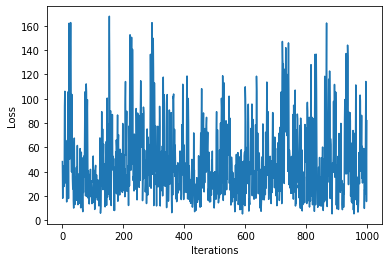

In [12]:
loss = train_pipeline.v('loss')
plt.xlabel("Iterations"), plt.ylabel("Loss")
plt.plot(loss[1000:])

In [13]:
test_pipeline = (test_data.p
                      .import_model('my_model', train_pipeline) 
                      .init_variable('true', [])
                      .init_variable('traces', [])
                      .init_variable('predictions', [])
                      .load(components='raw', fmt='segy')
                      .load(components='markup', fmt='picks')
                      .standardize(src='raw', dst='raw')
                      .apply_transform_all(src='raw', dst='raw', func=lambda x: np.stack(x))                 
                      .add_components(components='predictions')
                      .predict_model('my_model', B('raw'), fetches='predictions',
                                       save_to=B('predictions', mode='a'))
                      .update(V('predictions', mode='a'), B('predictions'))
                      .update(V('traces', mode='a'), B('raw'))
                      .update(V('true', mode='a'), B('markup'))
                      .run_later(500, n_epochs=1, drop_last=False, shuffle=False, bar=True))

In [14]:
test_pipeline.run()

100%|██████████| 9/9 [00:01<00:00,  5.56it/s]


In [15]:
true = np.concatenate(np.concatenate(test_pipeline.v('true')))
true = np.around(true / 2)

pred = np.concatenate(np.concatenate(test_pipeline.v('predictions')))
pred = np.around(pred / 2)

traces = np.concatenate(np.concatenate(test_pipeline.v('traces')))

In [16]:
mae = np.mean(np.abs(true - pred))

In [17]:
print('MAE on test - {}'.format(mae))

MAE on test - 48.301776531089295


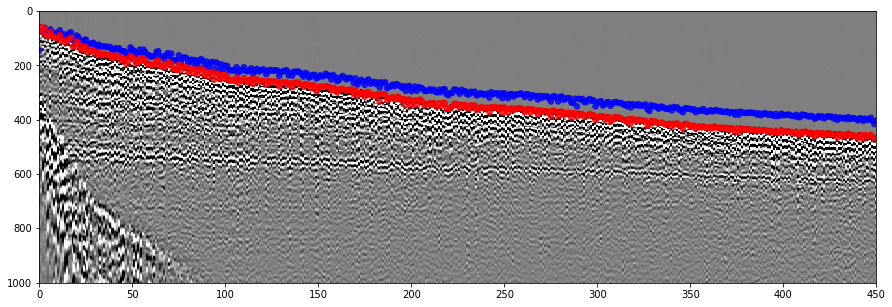

In [18]:
cv = 1
std = 0.1
xlim = (0, 450)

pts_pred = (range(len(pred)), pred)
pts_true = (range(len(true)), true)

seismic_plot(traces, cmap='gray', vmin=-cv, vmax=cv, pts=[pts_pred, pts_true], s=30,
             scatter_color=['b', 'r'], figsize=(15,5), xlim=xlim)

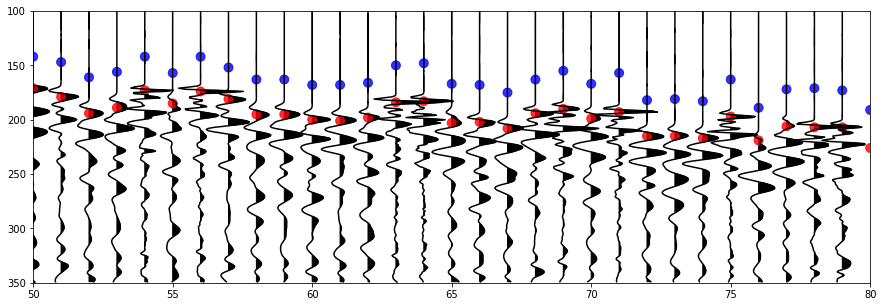

In [19]:
xlim = (50, 80)
ylim = (100, 350)

pts_pred = (range(len(pred)), pred)
pts_true = (range(len(true)), true)

seismic_plot(traces, cmap='gray', vmin=-cv, vmax=cv, pts=[pts_pred, pts_true], s=80,
             scatter_color=['b', 'r'], figsize=(15,5),
             xlim=xlim, ylim=ylim, wiggle=True, std=std)